In [1]:
using PyPlot
using LinearAlgebra
using Statistics

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [2]:
struct PeriodicBC end
struct PeriodicSolverGradientOperator
    nx :: Int64
    δx :: Vector{Float64}
end

(∇::PeriodicSolverGradientOperator)(u) = begin
    δx = ∇.δx
    nx = ∇.nx
    dudx = zeros(nx + 1)
    dudx[1] = # ...
    dudx[nx+1] = (u[nx] - u[1]) / (δx[1] + δx[nx+1])
    dudx[2:nx].= (u[1:nx-1] .- u[2:nx]) ./ δx[2:nx]
    return dudx
end

In [3]:
struct PeriodicSolver
    nx :: Int64
    Δx :: Vector{Float64}
    δx :: Vector{Float64}
    u  :: Vector{Float64}
    
    tol :: Float64
    maxiter :: Int64
end

PeriodicSolver(xf; tol=1e-15, maxiter=100) = begin
    Δx = diff(xf)
    nx = length(Δx)
    xc = cumsum(Δx) .- 0.5Δx
    δx = diff([first(xf); xc; last(xf)])
    
    return PeriodicSolver(nx, Δx, δx, similar(xc), tol, maxiter)
end

apply!(::PeriodicSolver, ::PeriodicBC) = nothing

solution(ps::PeriodicSolver) = ps.u
gradient(ps::PeriodicSolver) = PeriodicSolverGradientOperator(ps.nx, ps.δx)

gradient (generic function with 1 method)

In [4]:
# iterative methods
function jacobi(x, b; K=100, ϵ=1e-10)
    nx = length(x)
    xi = copy(x)
    xj = similar(x)
    dx = similar(x)
    
    it = K
    for k = 1:K
        dx .= abs.(xi .- xj)
        last_norm = sum(dx)
        @inbounds xj[1] =              (xi[2]       + xi[nx]    + b[1])      / 2.0
        @inbounds xj[2:nx-1] .= @views (xi[1:nx-2] .+ xi[3:nx] .+ b[2:nx-1])./ 2.0
        @inbounds xj[nx]=              (xi[nx-1]    + xi[1]     + b[nx])     / 2.0

        xi, xj = xj, xi

        dx .= abs.(xi .- xj)
        if abs(sum(dx) - last_norm) < ϵ
            it = k
            break
        end
    end
    
    x .= 0.5 .* (xi .+ xj .- mean(xi) .- mean(xj))
    return it
end

function solve!(ps::PeriodicSolver, rhs)
    b = rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u .= randn(ps.nx)
    jacobi(ps.u, b; K=ps.maxiter, ϵ=ps.tol)
end

solve! (generic function with 1 method)

In [5]:
using SparseArrays

struct LinearPeriodicSolver
    nx :: Int64
    Δx :: Vector{Float64}
    δx :: Vector{Float64}
    
    A :: SparseMatrixCSC{Float64, Int64}
    b :: Vector{Float64}
    u :: Vector{Float64}
end

LinearPeriodicSolver(xf) = begin
    Δx = diff(xf)
    nx = length(Δx)
    xc = cumsum(Δx) .- 0.5Δx
    δx = diff([first(xf); xc; last(xf)])
    
    A  = spdiagm(0 => 2ones(nx),
                -1 => -ones(nx-1),
                +1 => -ones(nx-1))
    A[1,nx] = -1.0
    A[nx,1] = -1.0
    b  = zeros(nx)
    return LinearPeriodicSolver(nx, Δx, δx, A, b, similar(xc))
end

apply!(::LinearPeriodicSolver, ::PeriodicBC) = nothing

solution(ps::LinearPeriodicSolver) = ps.u
gradient(ps::LinearPeriodicSolver) = PeriodicSolverGradientOperator(ps.nx, ps.δx)

gradient (generic function with 2 methods)

In [6]:
import IterativeSolvers

function solve!(ps::LinearPeriodicSolver, rhs)
    b = rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u  .= rand(ps.nx)
    IterativeSolvers.cg!(ps.u, ps.A, b)
    ps.u .-= mean(ps.u)
    return NaN
end

solve! (generic function with 2 methods)

In [7]:
struct MutligridSolver end
struct FastFourierTransformSolver end

In [8]:
xf = 0.0:0.01:1.0
ps = LinearPeriodicSolver(xf)

xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = -sin.(2π * 2xc)

f(x) = (2π * 2)^2 * sin(2π * 2x)
ρ = f.(xc)
nothing

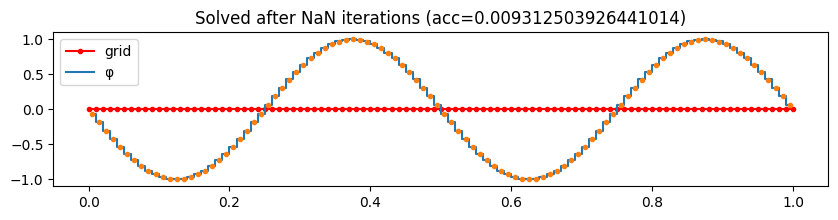

In [9]:
it = solve!(ps, -ρ)
φ  = solution(ps)
figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ"]);

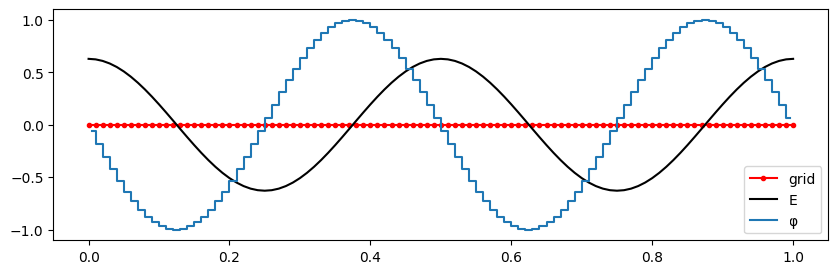

In [10]:
∇ = gradient(ps)
E = ∇(φ)
figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);